## Demo code for the paper "IQA-Adapter: Exploring Knowledge Transfer from Image Quality Assessment to Diffusion-based Generative Models"

### IQA-Adapter

Weights for IQA-Adapter can be downloaded from [here](https://drive.google.com/drive/folders/1jVYM96nbk0pUV4HSHiUzWGlTSLg-dv5h?usp=sharing) (Google Drive link)

In [ ]:
import torch
from pytorch_lightning import seed_everything
from diffusers import StableDiffusionXLPipeline, StableDiffusionXLImg2ImgPipeline

In [2]:
# visualization function
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import ImageGrid
extent = (0, 1024, 0, 768)

def image_grid_mpl(imgs, rows, cols, figscale=7, dpi=100, savepath=None, inset_coords={}, inset_poses=[], coords=[0,0,0,0]):
    fig = plt.figure(figsize=(figscale * cols, figscale * rows), dpi=dpi)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.05)
    i = 0
    for ax, im in zip(grid, imgs):
        ax.imshow(np.array(im))
        ax.set_axis_off()
        if i in inset_poses:
            x1, x2, y1, y2 = coords  # subregion of the original image
            axins_clear = ax.inset_axes(
                inset_coords[i],
                xticklabels=[], yticklabels=[])
            axins_clear.imshow(np.array(im)[y1:y2,x1:x2], extent=(x1, x2, y1, y2))
            axins_clear.set_xticks([])
            axins_clear.set_yticks([])
            ax.indicate_inset_zoom(axins_clear, edgecolor="red", linewidth=2.5, alpha=1.0)
            axins_clear.patch.set_linewidth(3)
            axins_clear.patch.set_edgecolor('red') 
        i += 1
    if savepath is not None:
        fig.savefig(savepath, )

In [ ]:
import os
base_model_path = "stabilityai/stable-diffusion-xl-base-1.0"
local_cache_dir = None # overrides default HF cache dir
weights_path = './weights' # directory with weights of IQA-Adapter and Ref.-based IQA-Adapter
iqa_adapter_ckpt = os.path.join(weights_path, 'iqa_adapter.bin')
ref_adapter_ckpt_path = os.path.join(weights_path, 'reference_iqa_adapter.bin')
device = "cuda"

In [ ]:
# load SDXL pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    base_model_path,
    use_safetensors=True, torch_dtype=torch.bfloat16, 
     cache_dir=local_cache_dir,
    add_watermarker=False,
    local_files_only=True
).to(device)

Loading pipeline components...: 100%|██████████| 7/7 [09:29<00:00, 81.37s/it] 


In [4]:
from PIL import Image
from iqa_adapter import IQAAdapterXL

In [6]:
in_dim=2
iqa_conditioned_model = IQAAdapterXL(pipe, ip_ckpt=iqa_adapter_ckpt, 
                         device=device, num_tokens=2, input_dim=in_dim, 
                         load_pretrained=True, adapter_dtype=torch.bfloat16, 
                         enable_neg_guidance=False, neg_guidance_scale=0.0)

loaded


In [ ]:
# increase for better quality of visualizations
DPI = 50

In [ ]:

metric_1 = 'topiq_nr'
metric_2 = 'laion_aes'
seed = 1
prompt = "beautiful illustration of electronic japanese gardens, trending on pixiv, artstation"
neg_prompt = ''
img_list_1d = []
lim = 1.55
g_scale = 7.5
res = 1024
# quality vals on the edges
lim_iqa = 2.5
lim_aes = 2.6
# scale of the adapter (lambda)
scale = 0.7

# controls negative guidance
iqa_conditioned_model.enable_neg_guidance = False
# delta
iqa_conditioned_model.neg_guidance_scale = 0.0

imgs_id = []
for i,iqa_score in enumerate([lim_iqa, 0, -lim_iqa]):
   for j,aes_score in enumerate([-lim_aes, 0, lim_aes]):
        with torch.no_grad():
            q_vec = torch.tensor([iqa_score, aes_score]).reshape(-1, 2).to(device, dtype=torch.float16)
            seed_everything(seed)
            cur_images = iqa_conditioned_model.generate(target_quality_vals=q_vec.repeat(1, 1), scale=scale,
                                            prompt=prompt, negative_prompt=neg_prompt,
                                            num_samples=1, num_inference_steps=35, guidance_scale=g_scale, width=res, height=res)
            imgs_id.append(cur_images[0])


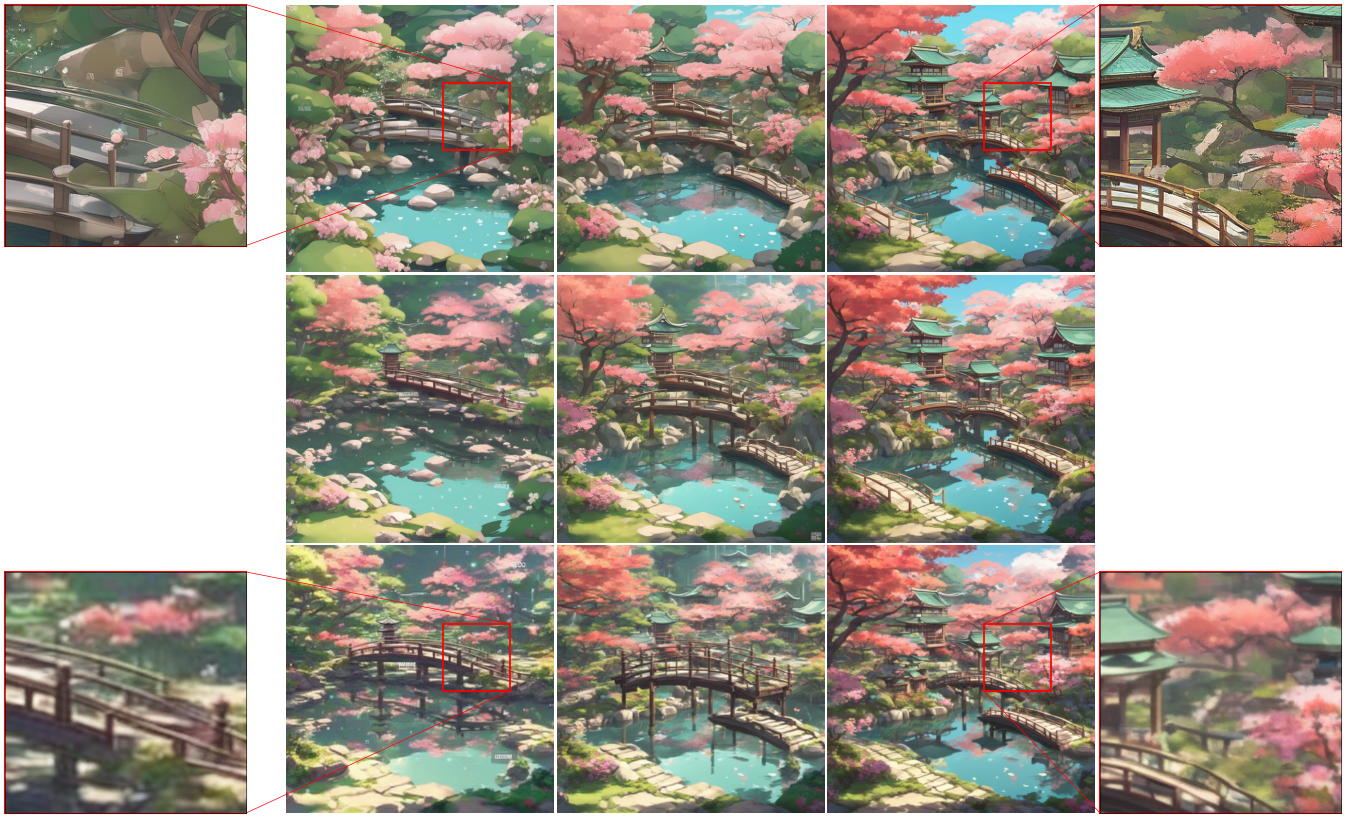

In [ ]:
# 1st visualisation from the paper

# shifts of the crops relative to the image being cropped
inset_coords = { 6:[-1.05, 0, 0.9, 0.9],
                         2:[1.02,0.1,0.9,0.9],
                         0:[-1.05, 0.1, 0.9, 0.9],
                         8:[1.02,0.0,0.9,0.9]}
# numbers of images to crop (edges)
inset_poses = [6,2,0,8] 
coords = [600, 856, 300, 556] # x1, x2, y1, y2
image_grid_mpl(imgs_id, 3, 3, savepath=None, dpi=DPI, inset_coords=inset_coords, inset_poses=inset_poses, coords=coords)

In [10]:
# same prompt and seed, without the adapter (scale = 0)
scale = 0
seed = 1
iqa_conditioned_model.enable_neg_guidance = False 
q_vec = torch.tensor([0, 0]).reshape(-1, 2).to(device, dtype=torch.bfloat16)
seed_everything(seed)
img_wo_adapter = iqa_conditioned_model.generate(target_quality_vals=q_vec.repeat(1, 1), scale=scale,
                                            prompt=prompt, negative_prompt=neg_prompt,
                                            num_samples=1, num_inference_steps=35, guidance_scale=g_scale, width=res, height=res)[0]


Seed set to 1
100%|██████████| 35/35 [00:08<00:00,  4.32it/s]


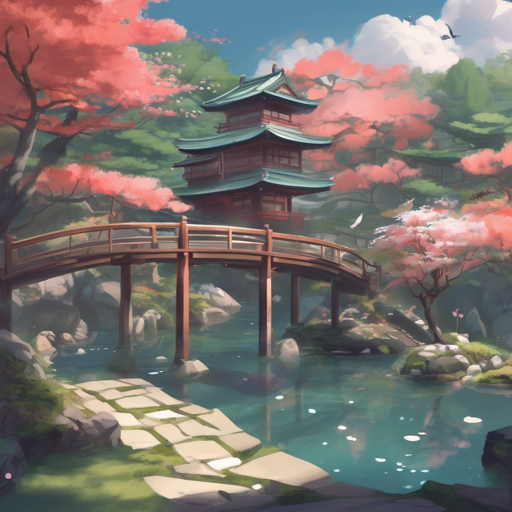

In [11]:
img_wo_adapter.resize((512,512))

In [ ]:
import pandas as pd 
# dataframe with stats of different metrics calculated on training dataset (CC3M)
# we use quantiles 1 - 99 percentiles from here as discrete quality levels
# percentiles serve as a relatively model-independent quality scale
stats_df = pd.read_csv('assets/CC3M_stats.csv', index_col=0)

In [13]:
seed = 42
m1 = 'topiq_nr'
m2 = 'laion_aes'
prompt = 'photo of a narrow istanbul street, old cozy building covered in leaves. 35mm photo, vintage, highly detailed, photorealistic, intricate'
neg_prompt = 'cartoon'

g_scale = 7.5
iqa_conditioned_model.enable_neg_guidance = True
neg_g_scale = 0.25

h = 1000
w = 1344

scale=0.65

quants = [1, 50, 99]
quants_imgs = []
with torch.no_grad():
    for quant in quants:
      iqa_val = stats_df[stats_df.metric == f'{m1}_normalized'][f'quantile_{quant}'].values[0]
      aes_val = stats_df[stats_df.metric == f'{m2}_normalized'][f'quantile_{quant}'].values[0]
      q_vec = torch.tensor([iqa_val, aes_val]).reshape(-1, 2).to(device, dtype=torch.bfloat16)
      iqa_conditioned_model.neg_guidance_scale = neg_g_scale
      seed_everything(seed)
      cur_images = iqa_conditioned_model.generate(target_quality_vals=q_vec, scale=scale,
                                      prompt=prompt, negative_prompt=neg_prompt,
                                        num_samples=1, num_inference_steps=50, guidance_scale=g_scale, width=w, height=h)
      quants_imgs.append(cur_images[0])

Seed set to 42
100%|██████████| 50/50 [00:14<00:00,  3.45it/s]
Seed set to 42
100%|██████████| 50/50 [00:14<00:00,  3.46it/s]
Seed set to 42
100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


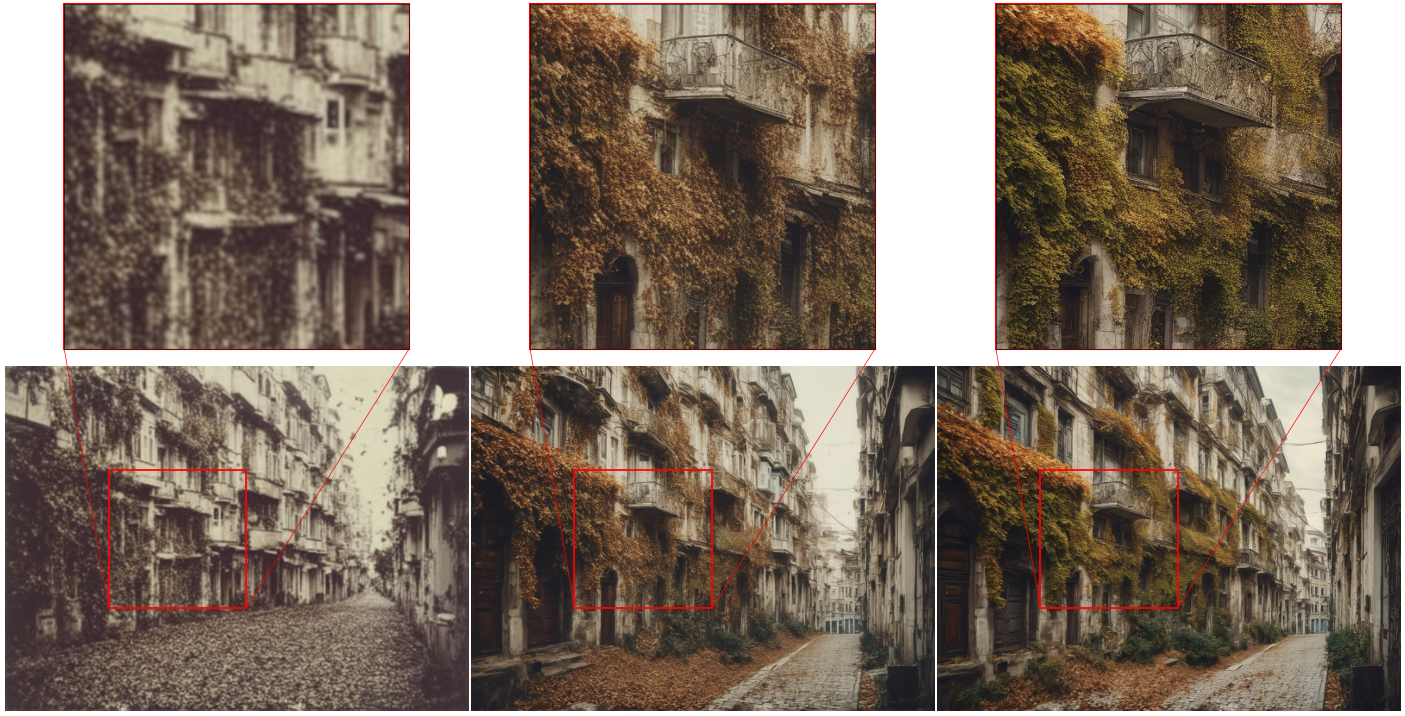

In [16]:
plot_data = quants_imgs
inset_coords = {
    i:[0,1.05,1,1] for i in range(len(plot_data))
}
inset_poses = [
    i for i in range(len(plot_data))
]
coords = [300, 700, 300, 700]
savepath = None
image_grid_mpl(plot_data, rows=1, cols=len(plot_data), inset_coords=inset_coords, inset_poses=inset_poses, coords=coords, figscale=12, savepath=savepath, dpi=DPI)

### Reference-based IQA-Adapter

In [ ]:
# load SDXL Image-to-Image pipeline
# You can also use previous T2I pipeline
# you may need to restart the kernel to free VRAM from the t2i pipeline
pipe_i2i = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    base_model_path,
    use_safetensors=True, torch_dtype=torch.bfloat16, 
     cache_dir=local_cache_dir,
    add_watermarker=False,
    local_files_only=True
).to('cuda')



Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.47it/s]


In [ ]:
from PIL import Image
from iqa_adapter import RefBasedIQAAdapterXL
in_dim=2048 # dimensions of the IQA Embeddings
iqa_conditioned_model = RefBasedIQAAdapterXL(pipe_i2i, ip_ckpt=ref_adapter_ckpt_path, 
                         device=device, num_tokens=2, input_dim=in_dim, 
                         load_pretrained=True, adapter_dtype=torch.bfloat16, 
                         enable_neg_guidance=False)

loaded


In [8]:
# qualitative embeddings are extracted from ARNIQA IQA model from the last layer of image encoder
# !pip install pyiqa
import pyiqa 

activation = {}
def getActivation(name):
    def hook(model, inp, out):
        activation[name] = out.detach().reshape(out.shape[0], -1)
    return hook

metric_2_layer = {'arniqa-kadid': 'encoder_8'}
metric_name = 'arniqa-kadid'
model = pyiqa.create_metric(metric_name, as_loss=False, device=device, loss_reduction='none',)
layer_name = metric_2_layer[metric_name]
h1 = model.net.encoder[8].register_forward_hook(getActivation(layer_name))


In [9]:
import os
import torchvision
distortion_names = ['motion_blur', 'jpeg', 'color_shift', 'pixelate']
distortion_ref_path = './assets'
# open reference images for distortions
distortion_refs = [Image.open(os.path.join(distortion_ref_path, f'{x}_ref.png')) for x in distortion_names]
# extract activations of the IQA model
ref_acts = []
for ref_img in distortion_refs:
    ref_img_tensor = torchvision.transforms.ToTensor()(ref_img).unsqueeze(0).to(device)
    val = model(ref_img_tensor)
    ref_acts.append(activation[layer_name].clone())


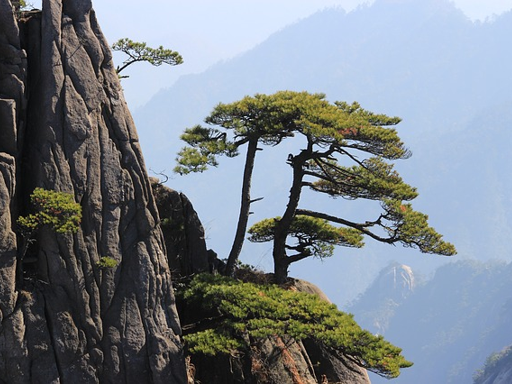

In [10]:
# Initial image for SDEdit
start_img = Image.open('./assets/I14.png')
start_img

In [ ]:
# Reproduce Figure 5 from the main paper
scale = 0.65
seed = 1
prompt = "the sun rises over the clouds in the sky"
neg_prompt = ''
g_scale = 7.5
results_ref_adapter = []
for ref_act in ref_acts:
    seed_everything(seed)
    res_img = cur_images = iqa_conditioned_model.generate(target_quality_vals=ref_act, scale=scale, strength=0.6, image=start_img.resize((start_img.size[0] * 2, start_img.size[1]*2)),
                                            prompt=prompt, negative_prompt=neg_prompt,
                                            num_samples=1, num_inference_steps=50, guidance_scale=g_scale)[0]
    results_ref_adapter.append(res_img)

['motion_blur', 'jpeg', 'color_shift', 'pixelate']


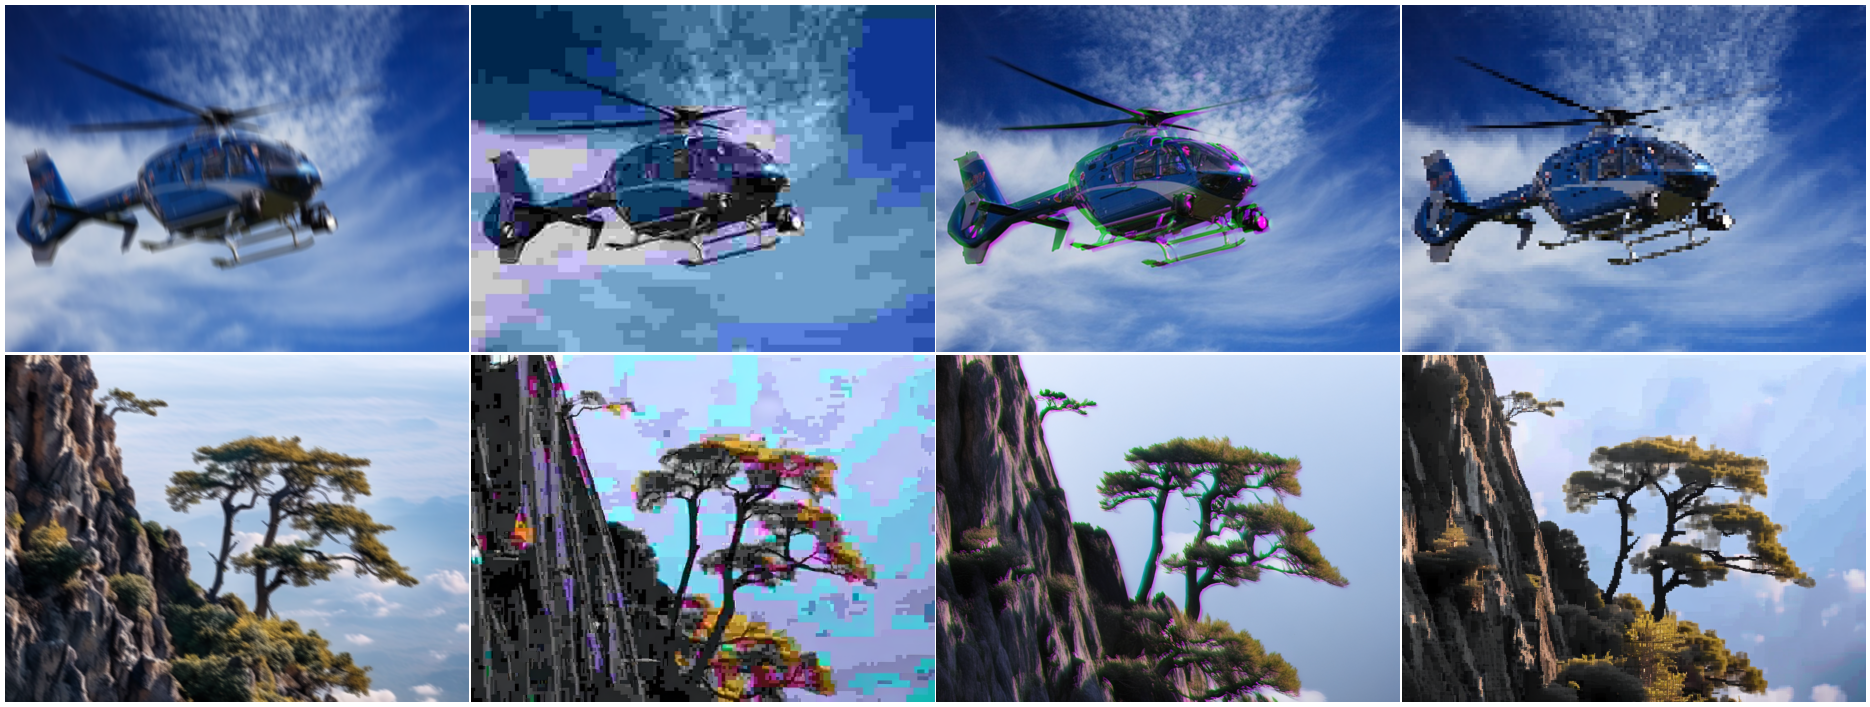

In [12]:
# first row indicates the distortion reference image
# and the second one demonstrates image editing result with corresponding reference
distortion_refs_resized = [x.resize(results_ref_adapter[0].size) for x in distortion_refs]
plot_data = distortion_refs_resized + results_ref_adapter
inset_coords = {
}
inset_poses = [
]
coords = [300, 700, 300, 700]
savepath = None
print(distortion_names)
image_grid_mpl(plot_data, rows=2, cols=4, inset_coords=inset_coords, inset_poses=inset_poses, coords=coords, figscale=12, savepath=savepath, dpi=DPI)